<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Определение-тренда" data-toc-modified-id="Определение-тренда-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Определение тренда</a></span></li><li><span><a href="#Определение-сезонности" data-toc-modified-id="Определение-сезонности-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Определение сезонности</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных-к-обучению-моделей" data-toc-modified-id="Подготовка-данных-к-обучению-моделей-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных к обучению моделей</a></span></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [107]:
# !pip install ydata_profiling

In [137]:
# Импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import (mean_squared_error as mse,
                             mean_absolute_error as mae)

from sklearn.model_selection import (train_test_split as tts,
                                     TimeSeriesSplit as tss,
                                     RandomizedSearchCV, GridSearchCV)

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
rs = [112263]

In [109]:
def rmse(test, predict):
    return ((mse(test, predict))**0.5).round(2)

In [110]:
# Импорт данных

try:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    
# try:
#     data = pd.read_csv('taxi.csv')
# except:
#     data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [111]:
# ProfileReport(data)

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [113]:
# data['datetime'] = pd.to_datetime(data['datetime'])
# data = data.set_index('datetime')

In [114]:
# Ресемпл данных по одному часу

data.sort_index(inplace=True)
data = data.resample('1H').sum()
data = data.sort_index(ascending=True)

data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [115]:
print(data.index.is_monotonic)

True


## Анализ

### Обзор данных 

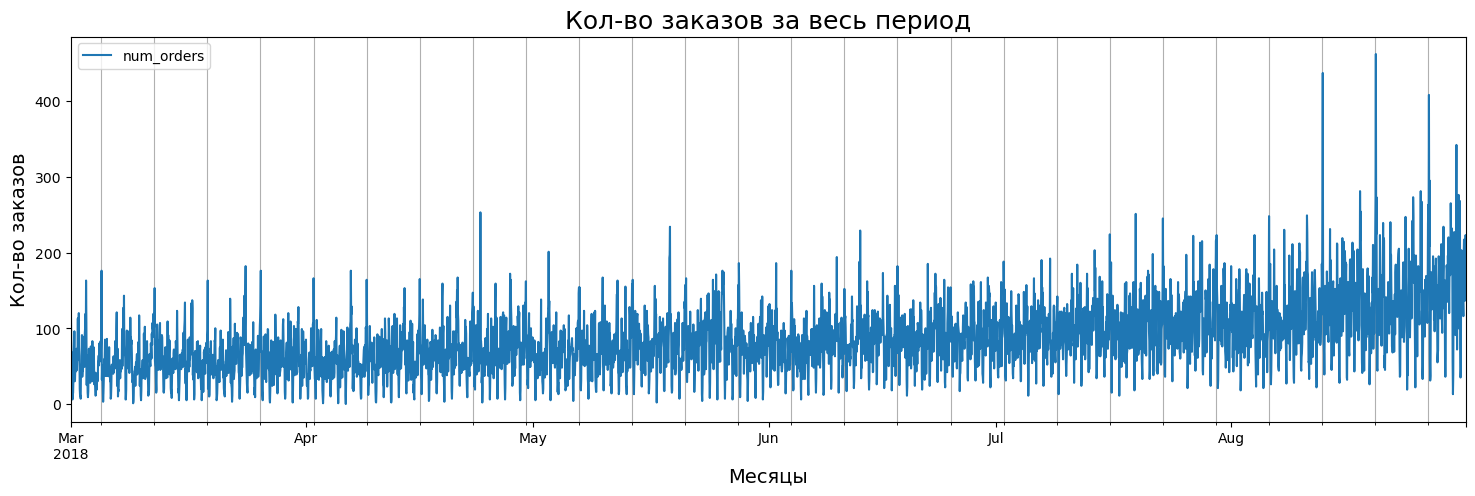

In [116]:
# График за все время

figsize = (18, 5)
data.plot(figsize=figsize)
plt.grid(which='minor')
plt.title('Кол-во заказов за весь период', fontsize=18)
plt.xlabel('Месяцы', fontsize=14)
plt.ylabel('Кол-во заказов', fontsize=14)
plt.show()


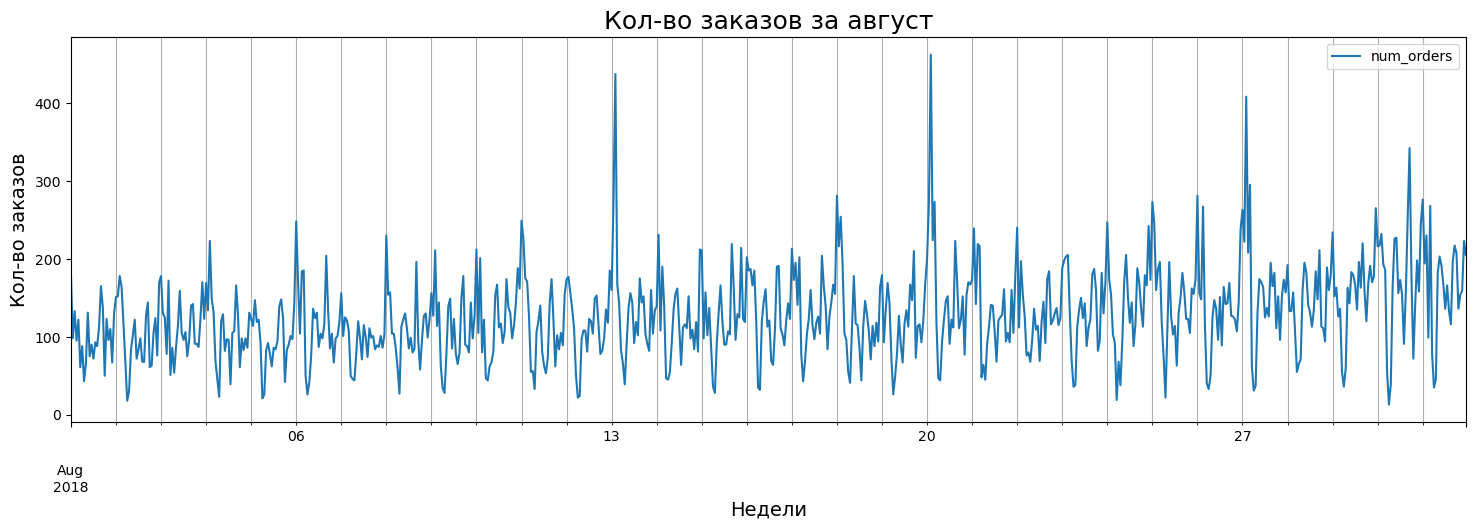

In [117]:
# График за август

figsize = (18, 5)
data_aug = data['2018-08-01':]
data_aug.plot(figsize=figsize)
plt.grid(which='minor')
plt.title('Кол-во заказов за август', fontsize=18)
plt.xlabel('Недели', fontsize=14)
plt.ylabel('Кол-во заказов', fontsize=14)
plt.show()


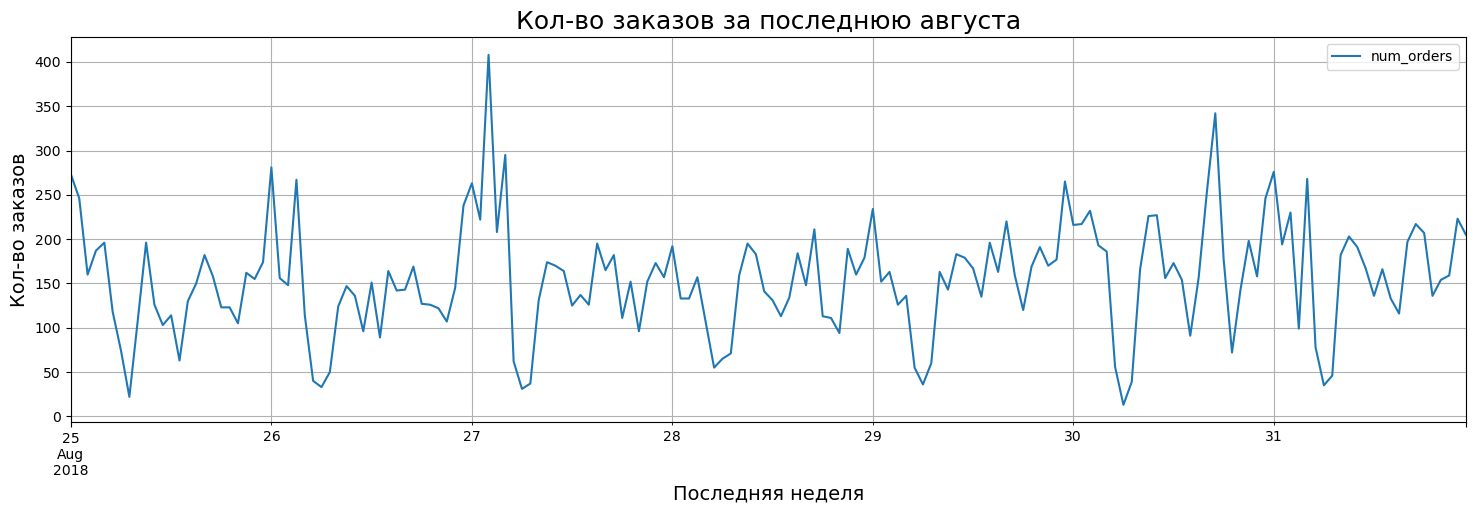

In [118]:
# График за последнюю неделю всего периода

figsize = (18, 5)
data_aug_last_week = data['2018-08-25':]
data_aug_last_week.plot(figsize=figsize)
plt.grid(which='both')
plt.title('Кол-во заказов за последнюю августа', fontsize=18)
plt.xlabel('Последняя неделя', fontsize=14)
plt.ylabel('Кол-во заказов', fontsize=14)
plt.show()


### Определение тренда

In [119]:
decomposed = seasonal_decompose(data)
decomposed_aug = seasonal_decompose(data_aug.num_orders)
decomposed_aug_last_week = seasonal_decompose(data_aug_last_week.num_orders)

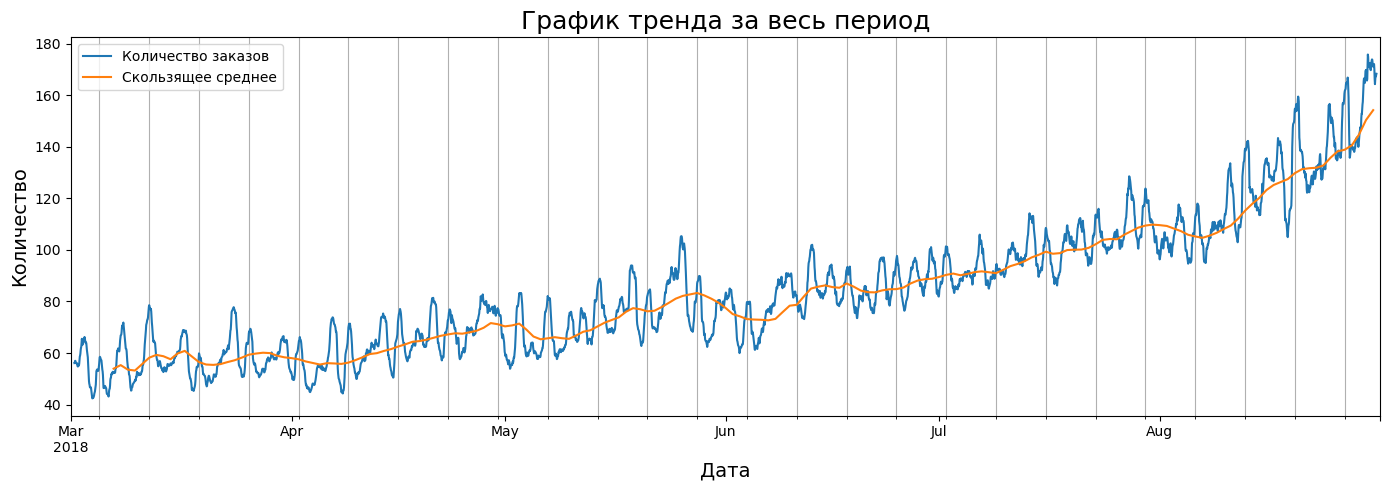

In [120]:
decomposed.trend.plot(ax=plt.gca(), figsize=(14, 5))
decomposed.trend.resample('1D').mean().rolling(7).mean().plot(ax=plt.gca(), figsize=(14, 5))
plt.grid(which='minor')
plt.legend(['Количество заказов', 'Скользящее среднее'])
plt.title('График тренда за весь период', fontsize=18)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.tight_layout()


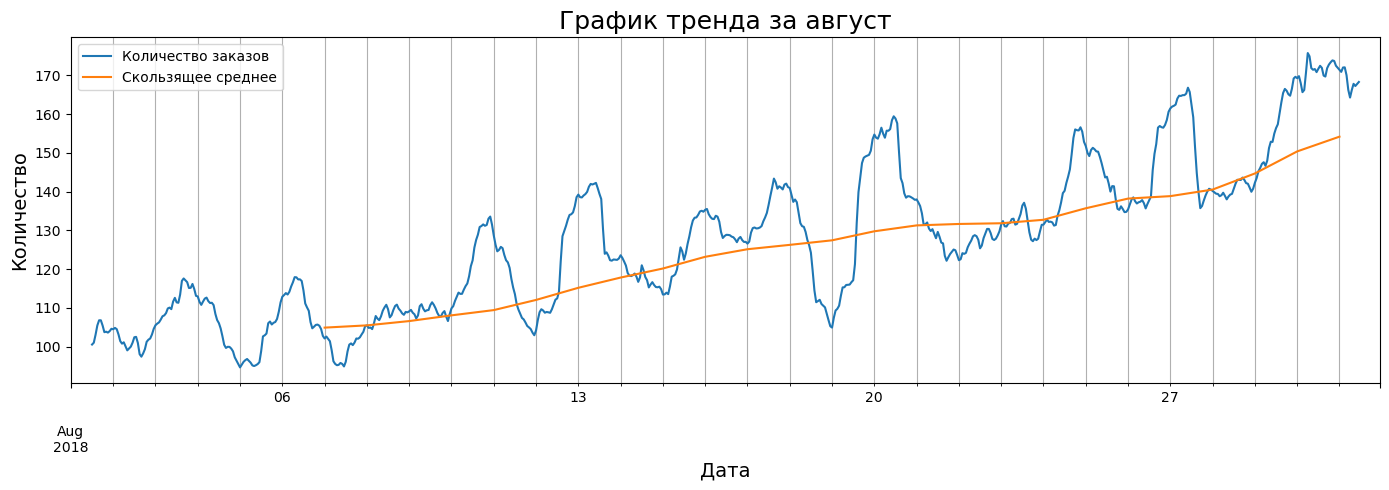

In [121]:
decomposed_aug.trend.plot(ax=plt.gca(), figsize=(14, 5))
decomposed_aug.trend.resample('1D').mean().rolling(7).mean().plot(ax=plt.gca(), figsize=(14, 5))
plt.grid(which='minor')
plt.legend(['Количество заказов', 'Скользящее среднее'])
plt.title('График тренда за август', fontsize=18)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.tight_layout()


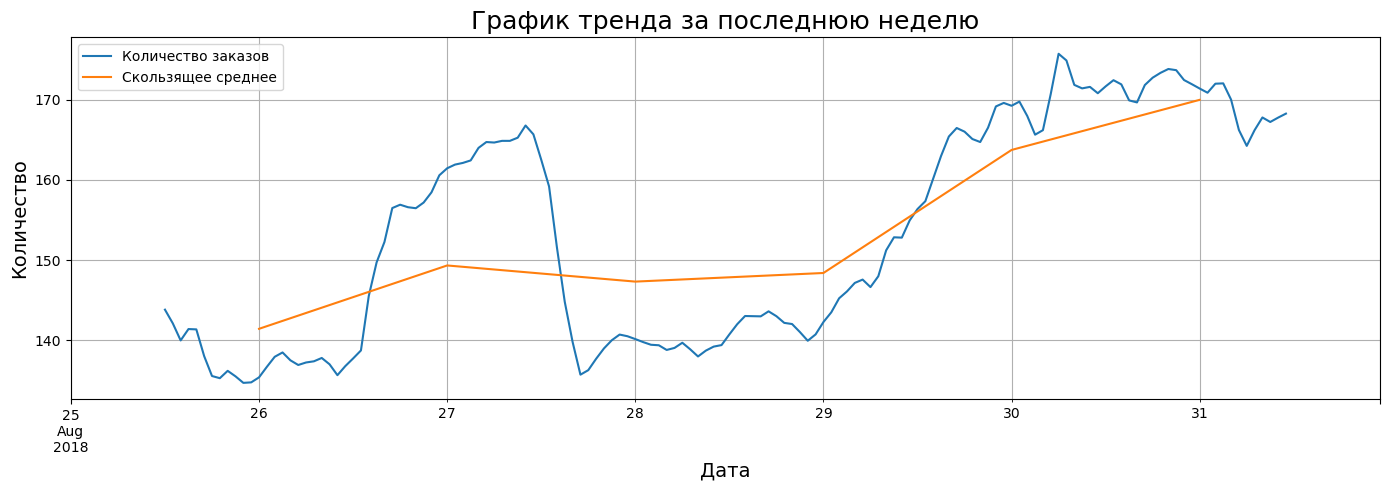

In [122]:
decomposed_aug_last_week.trend.plot(ax=plt.gca(), figsize=(14, 5))
decomposed_aug_last_week.trend.resample('1D').mean().rolling(2).mean().plot(ax=plt.gca(), figsize=(14, 5))
plt.grid(which='both')
plt.legend(['Количество заказов', 'Скользящее среднее'])
plt.title('График тренда за последнюю неделю', fontsize=18)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.tight_layout()


### Определение сезонности

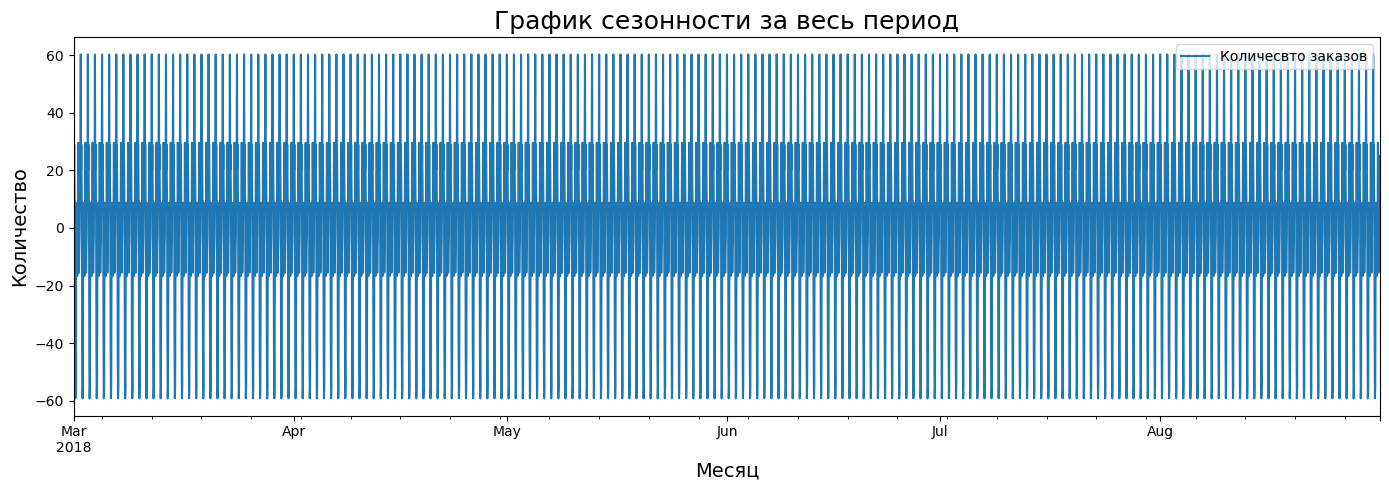

In [123]:
decomposed.seasonal.plot(ax=plt.gca(),figsize=(14, 5))
plt.legend(['Количесвто заказов'])
plt.title('График сезонности за весь период', fontsize=18)
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.tight_layout()


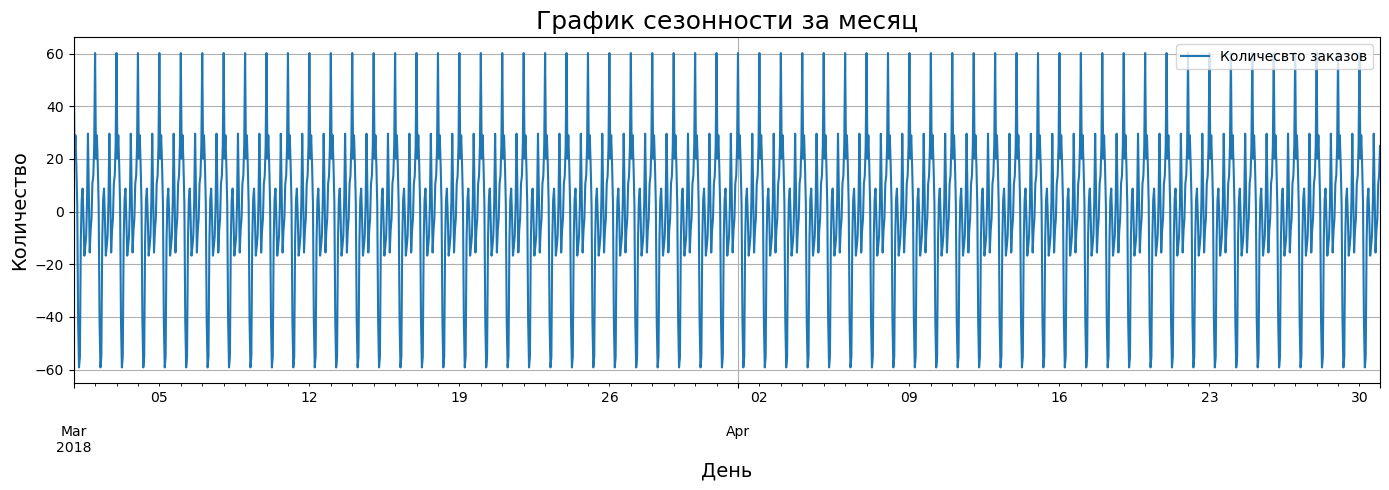

In [124]:
decomposed.seasonal['2018-03':'2018-04'].plot(ax=plt.gca(),figsize=(14, 5))
plt.grid(which='major')
plt.legend(['Количесвто заказов'])
plt.title('График сезонности за месяц', fontsize=18)
plt.xlabel('День', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.tight_layout()


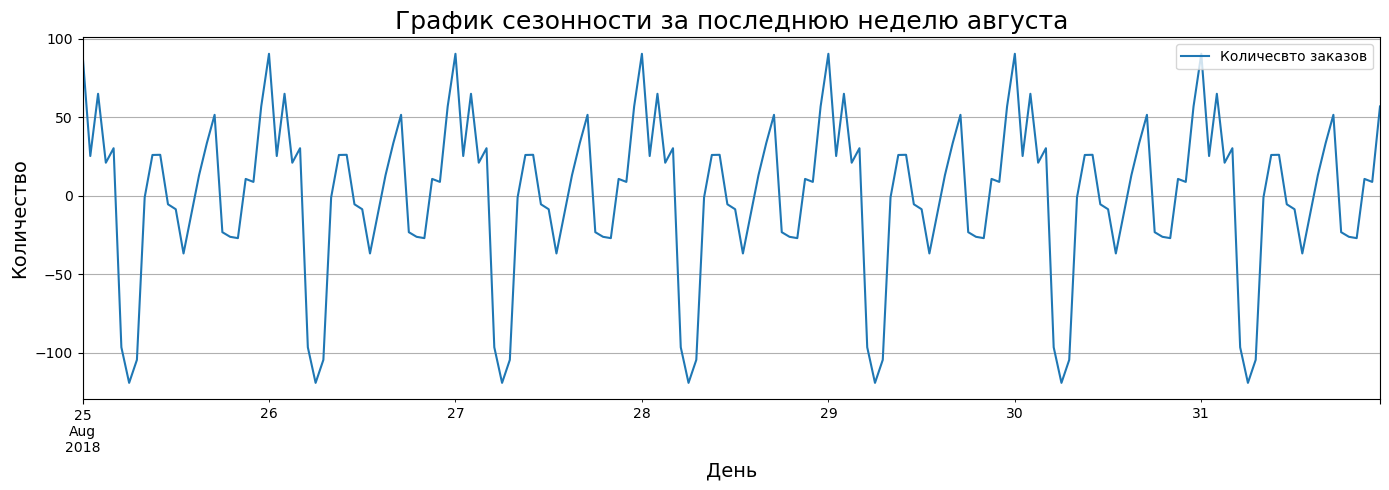

In [125]:
decomposed_aug_last_week.seasonal.plot(ax=plt.gca(),figsize=(14, 5))
plt.grid(which='major')
plt.legend(['Количесвто заказов'])
plt.title('График сезонности за последнюю неделю августа', fontsize=18)
plt.xlabel('День', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.tight_layout()


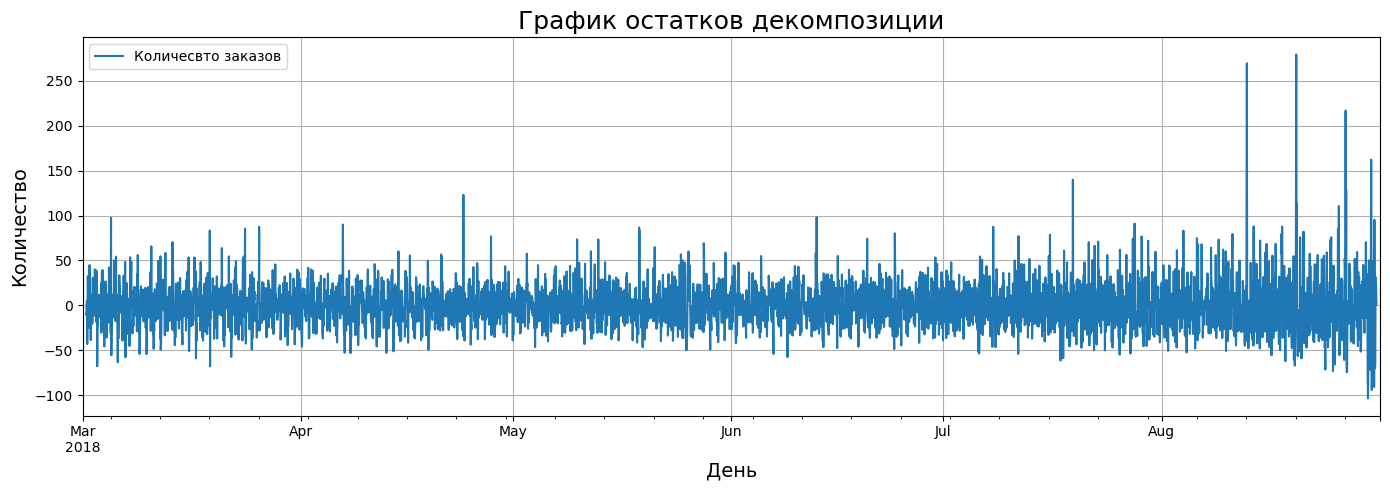

In [126]:
decomposed.resid.plot(ax=plt.gca(), figsize=(14, 5))
plt.grid(which='major')
plt.legend(['Количесвто заказов'])
plt.title('График остатков декомпозиции', fontsize=18)
plt.xlabel('День', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.tight_layout()

In [127]:
st_dev = round(decomposed.seasonal['2018-03':'2018-06'].std(), 2)
avg_value = abs(round(decomposed.seasonal['2018-03':'2018-06'].mean(), 2))


In [128]:
print(f'Стандотклон: {st_dev}')
print(f'Срзнач:      {avg_value}')

Стандотклон: 26.16
Срзнач:      0.0


## Обучение

### Подготовка данных к обучению моделей

In [130]:
def make_features(data, max_lag, rolling_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    
    data['hour']= data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_size).mean()

In [28]:
# make_features(data, 10, 7)

In [146]:
# data.head()

In [30]:
# train, test = tts(data, shuffle=False, test_size=0.1)
# train = train.dropna()

In [32]:
# train_features=train.drop('num_orders',axis=1)
# train_target=train['num_orders']
# test_features=test.drop('num_orders',axis=1)
# test_target=test['num_orders']


In [33]:
# # Размеры выборок
# print(f'Размер обучающей выборки: {train_features.shape} или {round((train_features.shape[0]/data.shape[0])*100, 0)}%')
# print(f'Размер тестовой выборки:  {test_features.shape}  или {round((test_features.shape[0]/data.shape[0])*100, 0)}%')

Размер обучающей выборки: (3964, 15) или 90.0%
Размер тестовой выборки:  (442, 15)  или 10.0%


### Linear Regression

Поскольку так и не поняв, какие параметры указывать `max_lag и rolling_size` для создания фичей. Для определения лучших параметров `max_lag и rolling_size`, воспользовался перебором этих параметров, ориентируясь на пакезатель RMSE модели LinearRegression

In [144]:
print('##'*50)

####################################################################################################


In [145]:
%%time
best_max_lag = 0
best_rolling_size = 0
best_mae_lr = 0
best_rmse_lr = 99999

for max_lag in tqdm(range(10, 51, 101), position=0, desc="max_lag", leave=False):
    for rolling_size in tqdm(range(7, 99, 7), position=1, desc="rolling_size", leave=False):
        make_features(data, max_lag, rolling_size)
            
        train, test = tts(data, shuffle=False, test_size=0.1)
        train = train.dropna()

        train_features=train.drop('num_orders',axis=1)
        train_target=train['num_orders']
        test_features=test.drop('num_orders',axis=1)
        test_target=test['num_orders']

        model_lr = LinearRegression()
        model_lr.fit(train_features, train_target)
        predict_lr = model_lr.predict(train_features)

        mae_lr = mae(train_target, predict_lr)
        rmse_lr = rmse(train_target, predict_lr)

        if rmse_lr < best_rmse_lr:
            best_rmse_lr = rmse_lr
            best_mae_lr = mae_lr
            best_max_lag = max_lag
            best_rolling_size = rolling_size
                
                
print('LinearRegression')
print('=='*25)
print(f'RMSE: {best_rmse_lr.round(2)}')
print(f'MAE:  {best_mae_lr.round(2)}')
print(f'Best max_lag:       {best_max_lag}')
print(f'Best rolling_size:  {best_rolling_size}')


rolling_size:  86%|██████████████████████████████████████████████████████████▎         | 12/14 [00:00<00:00, 55.15it/s]
                                                                                                                       

LinearRegression
RMSE: 23.28
MAE:  17.57
Best max_lag:       10
Best rolling_size:  56
Wall time: 266 ms


In [143]:
print('##'*50)

####################################################################################################


In [147]:
# model_lr = LinearRegression()
# model_lr.fit(train_features, train_target)
# predict_lr = model_lr.predict(train_features)

# mae_lr = mae(train_target, predict_lr)
# rmse_lr = rmse(train_target, predict_lr)


In [148]:
# print('LinearRegression')
# print('=='*25)
# print(f'RMSE: {rmse_lr.round(2)}')
# print(f'MAE:  {mae_lr.round(2)}')


### DecisionTreeRegressor

In [150]:
make_features(data, 10, 56)

In [151]:
train, test = tts(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [152]:
train_features=train.drop('num_orders',axis=1)
train_target=train['num_orders']
test_features=test.drop('num_orders',axis=1)
test_target=test['num_orders']

In [153]:
%%time
# DecisionTreeRegressor + RandomizedSearchCV


model_dtr = DecisionTreeRegressor()
max_depth_list = [x for x in range(2, 10)]
min_samples_split_list = [x for x in range(2, 10)]
min_samples_leaf_list = [x for x in range(2, 10)]
parameters = [{
    'criterion':['mae'], 
    'max_depth':max_depth_list, 
    'min_samples_split':min_samples_split_list, 
    'min_samples_leaf':min_samples_leaf_list, 
    'random_state':rs}]

rscv = RandomizedSearchCV(model_dtr, parameters, scoring='neg_mean_absolute_error')
rscv.fit(train_features, train_target)

best_model = rscv.best_estimator_
print(rscv.best_params_)

predict_dtr = best_model.predict(train_features)
mae_dtr = mae(train_target, predict_dtr)
rmse_dtr = mse(train_target, predict_dtr, squared=False)

{'random_state': 112263, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_depth': 6, 'criterion': 'mae'}


In [154]:
print('DecisionTreeRegressor')
print('=='*25)
print(f'При лучших гиперпараметрах: \n{rscv.best_params_}')
print(f'MAE:  {mae_dtr.round(2)}')
print(f'RMSE: {rmse_dtr.round(2)}')


DecisionTreeRegressor
При лучших гиперпараметрах: 
{'random_state': 112263, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_depth': 6, 'criterion': 'mae'}
MAE:  16.46
RMSE: 23.36


### CatBoostRegressor

In [155]:
%%time
# CatBoostRegressor + RandomizedSearchCV


model_cbr = CatBoostRegressor()
# Добавлять гиперпараметр глубины не стал, поскольку даже с randomized search считалось неприлично долго
parameters = [{'learning_rate': [.1, .15, .25], 'random_state':[112263], 'verbose': [False]}]

rscv = RandomizedSearchCV(model_cbr, parameters, scoring='neg_mean_absolute_error')
rscv.fit(train_features, train_target)

best_model = rscv.best_estimator_
print(rscv.best_params_)

predict_cbr = best_model.predict(train_features)
mae_cbr = mae(train_target, predict_cbr)
rmse_cbr = mse(train_target, predict_cbr, squared=False)

{'verbose': False, 'random_state': 112263, 'learning_rate': 0.1}
Wall time: 41.5 s


In [156]:
print('CatBoostRegressor')
print('=='*25)
print(f'При лучших гиперпараметрах: \n{rscv.best_params_}')
print(f'MAE:  {mae_cbr.round(2)}')
print(f'RMSE: {rmse_cbr.round(2)}')


CatBoostRegressor
При лучших гиперпараметрах: 
{'verbose': False, 'random_state': 112263, 'learning_rate': 0.1}
MAE:  4.14
RMSE: 5.29


### LGBMRegressor

In [157]:
%%time
# LGBMRegressor + RandomizedSearchCV


model_lgbmr = LGBMRegressor() 
parameters = [{'learning_rate': [.1, .15, .25], 'num_leaves':[50, 100, 200],'random_state':[112263]}]

rscv = RandomizedSearchCV(model_lgbmr, parameters, scoring='neg_mean_absolute_error')
rscv.fit(train_features, train_target)

best_model = rscv.best_estimator_
print(rscv.best_params_)

predict_lgbmr = best_model.predict(train_features)
mae_lgbmr = mae(train_target, predict_lgbmr)
rmse_lgbmr = mse(train_target, predict_lgbmr, squared=False)

{'random_state': 112263, 'num_leaves': 50, 'learning_rate': 0.1}
Wall time: 23.2 s


In [158]:
print('CatBoostRegressor')
print('=='*25)
print(f'При лучших гиперпараметрах: \n{rscv.best_params_}')
print(f'MAE:  {mae_lgbmr.round(2)}')
print(f'RMSE: {rmse_lgbmr.round(2)}')


CatBoostRegressor
При лучших гиперпараметрах: 
{'random_state': 112263, 'num_leaves': 50, 'learning_rate': 0.1}
MAE:  5.9
RMSE: 8.04


## Тестирование

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48